# table of contents
[1. 필요한 파일 불러오기 및 정리](#bullet1)<br>
[2. 데이터 EDA](#bullet2)<br>
[3. Split Data](#bullet3)<br>
[4. Similarity - with kNN](#bullet4)<br>
[5. Make Predictions](#bullet5)<br>

# 1. 필요한 파일 불러오기 및 정리<a class="anchor" id="bullet1"></a>


In [25]:
from scipy.stats import pearsonr
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [191]:
all_review = pd.read_csv('data/댓글합.csv', index_col = False)
all_book = pd.read_csv('data/전체합.csv', index_col = False)


In [12]:
# df = raw[['nickname', 'title',  'rating']]

# df.sample(5)

## 1.1 title_df, user_df 만들기<a class="anchor" id="bullet1.1"></a>

In [13]:
# user_df = pd.DataFrame(list(df.nickname	.unique()), columns = ['nickname'])
# user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

# title_df = pd.DataFrame(list(df.title.unique()), columns = ['title'])
# title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

# df = df.merge(user_df, how = 'left' )
# df = df.merge(title_df, how = 'left' )
# df.columns = ['user', 'title', 'rating', 'usr_id', 'ttl_id']
# df.sample()

In [14]:
# pivot_df = df.pivot_table('rating', index = 'user', columns = 'title')
# pivot_df.sample(4)

### 어떤 책이 폎ㅇ점이 높은지
### 회귀분석...!
추천시스템의 문제는 왜 추천했는지를 모른다는것!
고생을했는데 티가안난다는 문제
1. 팟빵에 추천시스템을 도입한다면...
2. 실패하면.. 약팔기 -> 사람들의 취향이 의외로 다양하지 않다! 의외로 취향이 균일해서 개인화 추천이 필요하지 않다! 이때 그 사람들의 취향이 어떤지 EDA로 보여주기


# 2. 데이터 EDA<a class="anchor" id="bullet2"></a>

### 유명인이 읽어주는 경우 vs 작가가 읽어주는 경우 vs 일반성우

null값을 찾자

In [193]:
# 작가가 없는 책 찾기
all_book[all_book['author'].isnull()].title.unique()

array(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어', '100인의 배우, 우리 문학을 읽다'],
      dtype=object)

[페이지](http://m.podbbang.com/audiobook/channel?id=1769055)를 들어가보면 목차 안으로 들어가야 각 책의 제목, 목소리, 작가를 알 수 있음 <br>
그런데 이 목차 안의 콘텐츠를 따로 빼서 제공하는 중이기도 함

In [194]:
all_book[all_book['title'].str.contains('원미동')]

,Unnamed: 0,title,voice,author,publish,genre
724,724,길해연이 읽는 양귀자의 원미동 시인,길해연,양귀자,커뮤니케이션북스,오디오북스


그러면 이 오디오북 시리즈에 대한 리뷰 따로, 특정 책에 대한 리뷰는 따로 해야할 듯

In [205]:
# voice가 없는 책 찾기
print(f"전체 책 수는 : {len(all_book.title.unique())}")
print(f"voice가 없는 책 수는 : {len(all_book[all_book['voice'].isnull()].title.unique())}")

전체 책 수는 : 1719
voice가 없는 책 수는 : 846


voice tag를 구분하자!

In [206]:
all_book

,Unnamed: 0,title,voice,author,publish,genre
0,0,"매향리, 평화가 오다",이미나,"화성시(기획),전혜진(글),김준현(사진)",화성시,소설문학
1,1,[이유영 낭독] 다정한 유전 _작은책,이유영,강화길,아르테,소설문학
2,2,저스트 어 모멘트,이나리,이경화,탐,소설문학
3,3,사춘기라서 그래,조현정,이명랑,탐,소설문학
4,4,[단편] 헤엄치는 밤,최인영,한유주,미디어창비,소설문학
...,...,...,...,...,...,...
1718,1718,땍때굴,NaN,김이구,창비,어린이동화
1719,1719,꿈틀꿈틀,NaN,김이구,창비,어린이동화
1720,1720,어린이를 위한 안데르센 영어동화,NaN,한스 크리스티안 안데르센,팟빵북스,어린이동화
1721,1721,7년 동안의 잠,유경선,박완서,어린이작가정신,어린이동화


In [ ]:
read_by_none = raw[raw['voice'].isnull()]
read_by_none

voice가 nan인건..?

In [157]:
read_by_none = raw[raw['voice'].isnull()]
read_by_none

,Unnamed: 0,title,nickname,rating,voice,author,genre
6164,6164,"시인 동주(하늘과 바람과 별과 시, 시 20편)",kwackbj,10,NaN,안소영,소설문학
6165,6165,"시인 동주(하늘과 바람과 별과 시, 시 20편)",꼬꼬리코돌격대,100,NaN,안소영,소설문학
6166,6166,"시인 동주(하늘과 바람과 별과 시, 시 20편)",sbunm12,100,NaN,안소영,소설문학
6167,6167,"시인 동주(하늘과 바람과 별과 시, 시 20편)",두두리,100,NaN,안소영,소설문학
6168,6168,"시인 동주(하늘과 바람과 별과 시, 시 20편)",기분전환하장,100,NaN,안소영,소설문학
...,...,...,...,...,...,...,...
17503,17503,[단편] 햇볕 동동 구리 동동,후후후크,90,NaN,윤기현,어린이동화
17504,17504,임진록,하루유,10,NaN,김종광,어린이동화
17505,17505,오세암,pink9964,90,NaN,정채봉,어린이동화
17506,17506,마법사 똥맨,소민맘,100,NaN,송언,어린이동화


In [158]:
titles =list(raw.title.unique())

In [159]:
read_by_author = list(raw.query('voice == author').title.unique())

In [160]:
read_by_celeb = [title for title in titles if ("낭독" in title) or ("읽는" in title)]

In [124]:
read_by_someone = [title for title in titles if title not in read_by_celeb and title not in read_by_author and title not in read_by_none['title']]

### 목소리별 평점 

In [92]:
raw[raw['title'].isin(read_by_author)].rating.describe()

count    2636.000000
mean       97.166161
std         9.023083
min        10.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: rating, dtype: float64

In [93]:
raw[raw['title'].isin(read_by_celeb)].rating.describe()

count    4157.000000
mean       94.166466
std        11.585528
min        10.000000
25%        90.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: rating, dtype: float64

In [94]:
raw[raw['title'].isin(read_by_someone)].rating.describe()

count    10715.000000
mean        94.883808
std         12.435123
min         10.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: rating, dtype: float64

In [105]:
cel = pd.DataFrame({"title": read_by_celeb, "voice":"celeb"})
aut = pd.DataFrame({"title": read_by_author, "voice":"author"})
som = pd.DataFrame({"title": read_by_someone, "voice":"someone"})

In [165]:
read_by = raw[['title', 'rating']]

In [167]:
read_by

,title,rating
0,저스트 어 모멘트,100
1,[단편] 헤엄치는 밤,100
2,[단편] 헤엄치는 밤,100
3,[단편] 헤엄치는 밤,100
4,[단편] 헤엄치는 밤,100
...,...,...
17503,[단편] 햇볕 동동 구리 동동,90
17504,임진록,10
17505,오세암,90
17506,마법사 똥맨,100


In [ ]:
read_by

In [153]:
read_by['voice'] = np.NaN

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [155]:
read_by['voice'] = read_by['title'].apply(lambda x : "celeb" if x in cel else ("author" if x in aut else "someone"))

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [156]:
read_by[read_by['title'].isin(read_by_celeb)]

,title,rating,voice
1213,[성진환 낭독] 나조차 나를 사랑하지 못하고,100,someone
1214,[성진환 낭독] 나조차 나를 사랑하지 못하고,100,someone
1215,[성진환 낭독] 나조차 나를 사랑하지 못하고,100,someone
1216,[성진환 낭독] 나조차 나를 사랑하지 못하고,100,someone
1217,[성진환 낭독] 나조차 나를 사랑하지 못하고,100,someone
...,...,...,...
17496,까칠한 아이(성우 낭독 버전),100,someone
17497,까칠한 아이(성우 낭독 버전),100,someone
17498,까칠한 아이(성우 낭독 버전),100,someone
17499,까칠한 아이(성우 낭독 버전),100,someone


In [108]:

read_by = read_by.merge(cel,on = 'title', how = 'left')
read_by = read_by.merge(aut,on = 'title', how = 'left')
read_by = read_by.merge(som,on = 'title', how = 'left')
read_by

,title,rating,voice_x,voice_y,voice
0,저스트 어 모멘트,100,NaN,NaN,someone
1,[단편] 헤엄치는 밤,100,NaN,NaN,someone
2,[단편] 헤엄치는 밤,100,NaN,NaN,someone
3,[단편] 헤엄치는 밤,100,NaN,NaN,someone
4,[단편] 헤엄치는 밤,100,NaN,NaN,someone
...,...,...,...,...,...
17503,[단편] 햇볕 동동 구리 동동,90,NaN,NaN,someone
17504,임진록,10,NaN,NaN,someone
17505,오세암,90,NaN,NaN,someone
17506,마법사 똥맨,100,NaN,NaN,someone


In [132]:
a = raw.iloc[:4]
a['new'] = a['nickname'].apply(lambda x : x if x == "하브" else(x+"hihi" if x == "양수" else "그냥"))

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [133]:
a

,Unnamed: 0,title,nickname,rating,voice,author,genre,new
0,0,저스트 어 모멘트,유노창민,100,이나리,이경화,소설문학,그냥
1,1,[단편] 헤엄치는 밤,나이스가이72,100,최인영,한유주,소설문학,그냥
2,2,[단편] 헤엄치는 밤,하브,100,최인영,한유주,소설문학,하브
3,3,[단편] 헤엄치는 밤,양수,100,최인영,한유주,소설문학,양수hihi


In [110]:
read_by.columns

Index(['title', 'rating', 'voice_x', 'voice_y', 'voice'], dtype='object')

In [112]:
read_by['real_voice'] = read_by[read_by.columns[2:]].apply("sum")

In [114]:
raw

,Unnamed: 0,title,nickname,rating,voice,author,genre
0,0,저스트 어 모멘트,유노창민,100,이나리,이경화,소설문학
1,1,[단편] 헤엄치는 밤,나이스가이72,100,최인영,한유주,소설문학
2,2,[단편] 헤엄치는 밤,하브,100,최인영,한유주,소설문학
3,3,[단편] 헤엄치는 밤,양수,100,최인영,한유주,소설문학
4,4,[단편] 헤엄치는 밤,티씨지는부산더락,100,최인영,한유주,소설문학
...,...,...,...,...,...,...,...
17503,17503,[단편] 햇볕 동동 구리 동동,후후후크,90,NaN,윤기현,어린이동화
17504,17504,임진록,하루유,10,NaN,김종광,어린이동화
17505,17505,오세암,pink9964,90,NaN,정채봉,어린이동화
17506,17506,마법사 똥맨,소민맘,100,NaN,송언,어린이동화


{'whiskers': [<matplotlib.lines.Line2D at 0x2be330caa88>,
 'caps': [<matplotlib.lines.Line2D at 0x2be330d1d08>,
 'boxes': [<matplotlib.lines.Line2D at 0x2be330b8988>],
 'medians': [<matplotlib.lines.Line2D at 0x2be330d1e08>],
 'fliers': [<matplotlib.lines.Line2D at 0x2be330d9a48>],
 'means': []}

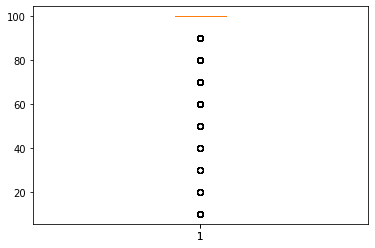

In [97]:
plt.boxplot(x = raw[raw['title'].isin(read_by_someone)].rating)
plt.boxplot(x = raw[raw['title'].isin(read_by_author)].rating)

In [68]:
plt.boxplot?

In [26]:
raw.title.unique()

array(['저스트 어 모멘트', '[단편] 헤엄치는 밤', '[단편] 펄럭이는 종이 스기마쓰 성서', '[단편] 돼지 먹이',
       '[단편] 어머니는 잠 못 이루고', '[단편] 소여', '들어본 이야기', '니가 뭔데 아니 내가 뭔데',
       '너의 거기는 작고 나의 여기는 커서 우리들은 헤어지는 중입니다', '시를 잊은 그대에게',
       '김용 대하역사무협 신조협려 하이라이트', '살고 싶다는 농담', '좀머 씨 이야기', '나만 몰랐던 이야기',
       '슬리피 할로우의 전설', '[성진환 낭독] 나조차 나를 사랑하지 못하고', '일의 기쁨과 슬픔',
       '[에이노 낭독] 상드리용 (단편)', '[윤도현 낭독] 바틀비 (단편)',
       '[Young K 낭독] 페이퍼 컷 (단편)', '[정인성 낭독] 지상 최대의 쇼 (단편)',
       '[이동원 낭독] 2098 스페이스 오디세이 (단편)', '[오희준 낭독] 페르시아양탄자 흥망사 (단편)',
       '[박서함 낭독] 교육의 탄생 (단편)', '[김지훈 낭독] 라면의 황제 (단편)',
       '[정세운 낭독] 너만 모르는 엔딩 (단편)', '블랙코미디', '[류현경 낭독] 암송 _ 작은책',
       '[김대명 낭독] 세계의 호수 _ 작은책', '[규빈 낭독] 배꼽 (단편)', '셰익스피어 4대 비극 - 맥베스',
       '셰익스피어 4대 비극 - 리어왕', '[김동한 낭독] 누군가의 마음 (단편)', '남편을 죽이는 서른 가지 방법',
       '나는 마음 놓고 죽었다', '[배다해 낭독] 세상의 모든 위로', '[태호 낭독] 수영장 (단편)',
       '[준 낭독] 좀도둑과 목격자 (단편)', '[와우 낭독] 지금 아니면 못 할 일 (단편)',
       '[김병관 낭독] 못 먹어도 go! (단편)', '[동훈 낭독] 울지 않는 이유 (단편)',
       '[찬 낭독] 정범기 추락 사건 (단편)', '[세트] 담배만

In [222]:
print(f"데이터의 크기는             : {df.shape}")
print(f"데이터에 포함된 유저의 수는 : {len(user_df)}")
print(f"데이터에 포함된 책의 수는   : {len(title_df)}")

데이터의 크기는             : (15965, 3)
데이터에 포함된 유저의 수는 : 4951
데이터에 포함된 책의 수는   : 200


C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


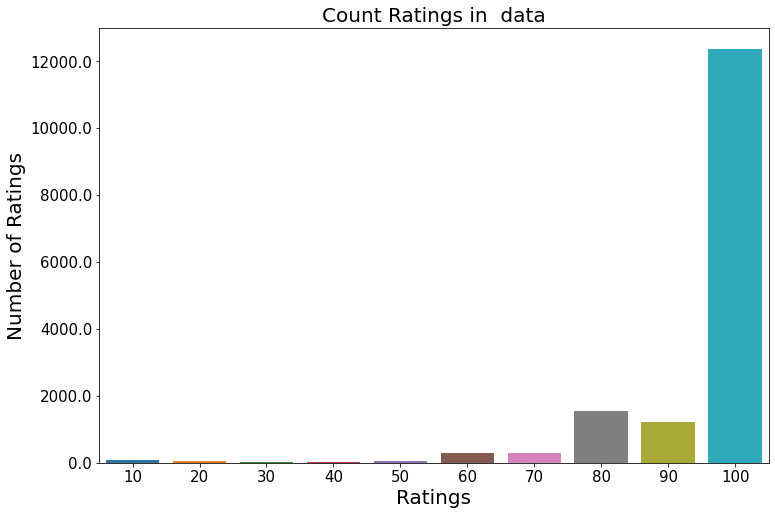

In [7]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=df)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in  data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

일단 가장 높은 n개의 값만 보여주는 함수를 만듭니다.

In [8]:
def return_best_n(statistics, n):
    # statistics: array of size review.shape[1] containing one statistic calculated from the dataset
    # n: number of indices to be returned
    # returns: array of size *n* containing the indices of the best scored statistics
    statistics = pd.DataFrame({'statistic':statistics})
    return statistics.sort_values('statistic', ascending = False).iloc[:n]

## 2.1 Mean Rating <a class="anchor" id="bullet2.1"></a>


In [9]:
means = pivot_df.iloc[:,2:].apply(np.mean)
return_best_n(means,10)

,statistic
title,
김의성이 읽는 최인호의 타인의 방,100.0
경제 읽어주는 남자 김광석의 [디지털 경제의 미래],100.0
너의 거기는 작고 나의 여기는 커서 우리들은 헤어지는 중입니다,100.0
정진영이 읽는 김기진의 젊은 이상주의자의 사,100.0
중국식 룰렛,100.0
나만 몰랐던 이야기,100.0
어린이 성경 : 알기 쉬운 성경이야기,100.0
김용 대하역사무협 신조협려 하이라이트,100.0
김영민이 읽는 현경준의 탁류,100.0


## 2.2 Rating Count<a class="anchor" id="bullet2.2"></a>


In [10]:
count = pivot_df.iloc[:,2:].apply(lambda col : np.sum(~np.isnan(col)))

# return_best_n(count,10).index 를 구하면 제목만 뽑을 수 있음
return_best_n(count,10)

,statistic
title,
최민식이 읽는 이범선의 오발탄,1445
운명이다,598
어른이 되면 괜찮을 줄 알았다,530
딜리트,521
[강연형] 제국대학의 조센징,498
담배만이 우리 세상,480
[한예리 낭독] 안락 _ 작은책,407
살고 싶다는 농담,392
나는 왠지 대박날 것만 같아!,391


평균 평점 top10의 책은 몇개의 리뷰가 있을까?

In [11]:
top10_avg_ratings = return_best_n(means,10).index
count.loc[top10_avg_ratings]

title
김의성이 읽는 최인호의 타인의 방                    5
경제 읽어주는 남자 김광석의 [디지털 경제의 미래]          1
너의 거기는 작고 나의 여기는 커서 우리들은 헤어지는 중입니다    2
정진영이 읽는 김기진의 젊은 이상주의자의 사              2
중국식 룰렛                                1
나만 몰랐던 이야기                            1
어린이 성경 : 알기 쉬운 성경이야기                  4
김용 대하역사무협 신조협려 하이라이트                  2
김영민이 읽는 현경준의 탁류                       1
길해연이 읽는 양귀자의 원미동 시인                   1
dtype: int64

## 2.3 Percentage of Good Ratings<a class="anchor" id="bullet2.3"></a>


In [12]:
good_count = pivot_df.iloc[:,2:].apply(lambda col : np.sum(col >=  80)/np.sum(~np.isnan(col)))
return_best_n(good_count,3)

,statistic
title,
<테이크아웃 오디오북> 목견,1.0
김의성이 읽는 최인호의 타인의 방,1.0
두 도시 이야기(요약본),1.0


In [13]:
#위 코드 이해하기
col = pivot_df.iloc[:,2:]['나는 왠지 대박날 것만 같아!']
print(np.sum(col >= 80))
print(np.sum(~np.isnan(col)))

387
391


애초에 리뷰가 한개인 경우는 리뷰 수 대비 좋은 리뷰 값이 1로 나옴<br>
이걸 해결하기 위해서 리뷰 숫자가 충분한 경우만 확인

In [14]:
means = pd.DataFrame(means, columns = ['rating_avg'])
count = pd.DataFrame(count, columns = ['no_of_ratings'])
rating_pct = pd.DataFrame(good_count, columns = ['over_80_ratio'])

ratings = pd.merge(left=means, right=count, how='left',left_index=True,right_index=True)

ratings = ratings.merge(rating_pct, how='left',left_index=True,right_index=True)

ratings.sample(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
편의점으로 먹고살기,100.0,3,1.0
[김병관 낭독] 못 먹어도 go! (단편),100.0,1,1.0
신안진이 읽는 이문열의 필론과 돼지,100.0,1,1.0


In [15]:
ratings.query('no_of_ratings > 100').sort_values(by='over_80_ratio', ascending=False).head(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
오만과 편견(요약본),99.339623,106,1.000000
열하일기 첫걸음,99.545455,352,0.997159
세계는 왜 싸우는가,99.171975,314,0.996815


<AxesSubplot:>

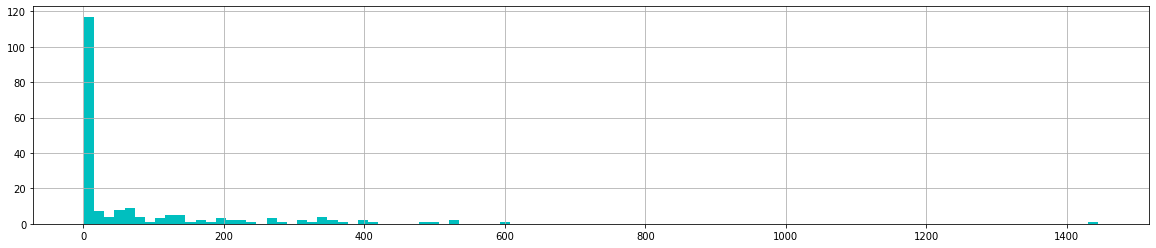

In [16]:
plt.figure(figsize = (20,4))
ratings['no_of_ratings'].hist(bins=100,color='c')

<AxesSubplot:>

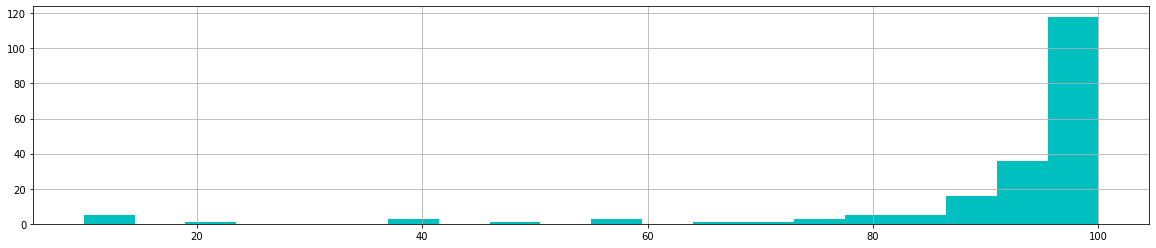

In [17]:
plt.figure(figsize = (20,4))
ratings['rating_avg'].hist(bins=20,color='c')

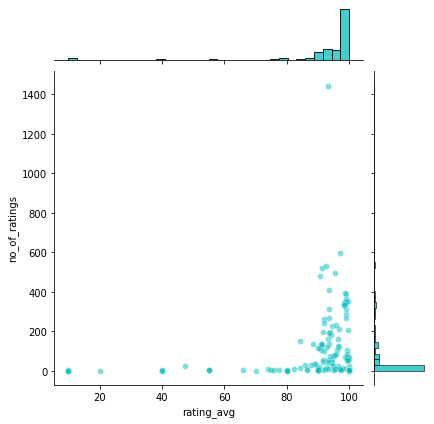

In [18]:
sns.jointplot(x='rating_avg', y='no_of_ratings', data= ratings, alpha = 0.5, color='c')

<div class="alert alert-warning">
분석에서 아래와 같이 rating이 몇개 이상인 책만 뽑아서 봐도 되는것...?
</div>

In [30]:
df.nickname

0            유노창민
1         나이스가이72
2              하브
3              양수
4        티씨지는부산더락
           ...   
17503        후후후크
17504         하루유
17505    pink9964
17506         소민맘
17507        유노창민
Name: nickname, Length: 17508, dtype: object

In [19]:
ratings['no_of_ratings'].describe()

count     198.000000
mean       79.727273
std       157.853708
min         1.000000
25%         1.000000
50%         6.000000
75%        86.750000
max      1445.000000
Name: no_of_ratings, dtype: float64

하위 50%의 분포를 살펴보면: 1~4정도임

In [20]:
ratings['no_of_ratings'].quantile(np.arange(0, 0.5, 0.05))

0.00    1.0
0.05    1.0
0.10    1.0
0.15    1.0
0.20    1.0
0.25    1.0
0.30    2.0
0.35    2.0
0.40    2.0
0.45    4.0
Name: no_of_ratings, dtype: float64

In [21]:
ratings_min_6 = ratings.query('no_of_ratings >= 6')
ratings_min_6.head(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
[강연형] 제국대학의 조센징,95.441767,498,0.945783
[공포괴담집] 무조건 모르는 척하세요,93.908629,197,0.949239
[공포괴담집] 저승에서 돌아온 남자,94.405286,227,0.964758


<div class="alert alert-warning">
근본적으로 우리가 책이 200권 정도밖에 없는데, <br>
리뷰 5개 이상인 책으로 바꾸면 그게 반토막 나게됨<br>
그렇게 데이터 수를 희생하면서 봐도 되는 것인지..?<br>
</div>

# 3. Split Data<a class="anchor" id="bullet3"></a>

<div class="alert alert-warning">
기본적으로 train의 목적은 prediction을 만들어내고<br>
validation으로 여러 알고리즘의 성능을 비교해서<br>
test에 최적의 알고리즘을 적용하는 것이라고 이해했는데 맞나?
</div>

<div class="alert alert-warning">
train(70%), test(10%), validation set(20%)으로 나눌 때<br>
유저 100명 중 70명은 train, 10명은 test, 20명은 validation으로 할당되게 해야하는 건지?<br>
랜덤하게 7:2:1을 (유저X)데이터에서 뽑아야할 것 같은데 맞는지?
</div>

In [22]:
df = df[['usr_id', 'ttl_id', 'rating']]
df.sample(3)

,usr_id,ttl_id,rating
5071,3926,99,100
13336,4210,47,100
177,2015,31,100


<div class="alert alert-warning">
애초에 우리 수준에서 validation까지 가야할까..<br>
</div>

<div class="alert alert-warning">
교차검증 하지 않고 두번째 방식처럼 단순하게 나눠도 되는 것..? <br>
교차검증은 test set을 여러개 만드는 방식으로 이해했는데, 아래 방식은 그런 용도도 아닌 것 같아서.. 
</div>

<div class="alert alert-warning">
아니 근데 나는 item based할건데 여기에 test, training 어케 왜 쓰는건데..?
</div>

In [ ]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(df, test_size=0.2)

In [24]:
df = df.sample(frac=1)
split_value = int(len(df) * 0.80)
train_data = df[:split_value]
test_data = df[split_value:]


## 3.2 Create User-Item Matrix<a class="anchor" id="bullet3.2"></a>

In [25]:
n_users = df.usr_id.unique().shape[0]
n_items = df.ttl_id.unique().shape[0]

In [26]:
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [27]:
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(4951, 200)
(4951, 200)


In [28]:
train_data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<div class="alert alert-warning">
이런 결과가 나오긴 햇는데 이게 제대로 나온건지는 어떻게 확인할 수 있나?
</div>

# 4. Similarity - with kNN<a class="anchor" id="bullet4"></a>

## 4.1 Cosine Similarity<a class="anchor" id="bullet4.1"></a>

In [29]:
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [30]:
print(user_similarity.shape)
print(item_similarity.shape)

(4951, 4951)
(200, 200)


In [31]:
user_similarity

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

<div class="alert alert-warning">
이렇게 극단적으로 0,1이 나올 수 있나?<br>
문제..없나...?
</div>

In [32]:
item_similarity

array([[0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.        , 1.        , ..., 0.81872862, 0.96570922,
        0.97249385],
       [1.        , 1.        , 0.        , ..., 0.98373531, 0.97261682,
        1.        ],
       ...,
       [1.        , 0.81872862, 0.98373531, ..., 0.        , 0.8421347 ,
        0.92475405],
       [1.        , 0.96570922, 0.97261682, ..., 0.8421347 , 0.        ,
        0.72570519],
       [1.        , 0.97249385, 1.        , ..., 0.92475405, 0.72570519,
        0.        ]])

## 4.2 Cosine Similarity (2) <a class="anchor" id="bullet4.2"></a>

<div class="alert alert-warning">
위 방식으로는 kNN어떻게 구해야할지 모르겠어서 새롭게 만들어봄!
</div>

#### item-item similarity

<div class="alert alert-warning">
그런데 이렇게 fillna해서 nan값을 0으로 바꿔도 되는 것...?맞...? cosine similarity라 괜찮은것?
pearson correlation만 안되는것?
</div>

In [33]:
from scipy.sparse import csr_matrix

In [34]:
train_item_pivot = train_data.pivot_table(index = 'ttl_id', columns = 'usr_id',values =  'rating').fillna(0)
train_item_matrix = csr_matrix(train_item_pivot)

In [35]:
train_item_matrix

<188x4264 sparse matrix of type '<class 'numpy.float64'>'
	with 12772 stored elements in Compressed Sparse Row format>

In [36]:
from sklearn.neighbors import NearestNeighbors


<div class="alert alert-warning">
k값 바꿔가면서 만들고 싶으면 여기부터 고쳐야하는것?
</div>

In [37]:
model_knn = NearestNeighbors(metric='cosine', algorithm = 'brute')
model_knn.fit(train_item_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

### prediction

<div class="alert alert-warning">
train_item_pivot이 아닌 test data사용해야?
</div>

In [61]:
query_index = np.random.choice(train_item_pivot.shape[0])

In [122]:
distances.flatten()

array([2.22044605e-16, 5.00000000e-01, 5.91751710e-01, 6.83772234e-01,
       1.00000000e+00, 1.00000000e+00])

In [63]:
distances, indices = model_knn.kneighbors(train_item_pivot.iloc[query_index, :].values.reshape(1,-1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f"Recommendations for {train_item_pivot.index[query_index]}")
    else:
        print(f'{i} : {train_item_pivot.index[indices.flatten()[i]]}, with distance of :{distances.flatten()[i]}')

Recommendations for 54
1 : 188, with distance of :0.5000000000000001
2 : 197, with distance of :0.5917517095361371
3 : 111, with distance of :0.6837722339831621
4 : 140, with distance of :1.0
5 : 139, with distance of :1.0


In [ ]:
query_index = np.random.choice(train_item_pivot.shape[0])

In [ ]:
distances, indices = model_knn.kneighbors(train_item_pivot.iloc[query_index, :].values.reshape(1,-1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f"Recommendations for {train_item_pivot.index[query_index]}")
    else:
        print(f'{i} : {train_item_pivot.index[indices.flatten()[i]]}, with distance of :{distances.flatten()[i]}')

제목으로 나오게 하고 싶어서!

In [40]:
title_df.sample(2)

,title,ttl_id
114,빨강머리 앤 : 에이번리 이야기,138
88,온(시 9편),191


In [43]:
title_df.index = title_df['ttl_id']
title_df = title_df[['title']]
title_df.sample(2)

,title
ttl_id,
126,송승환이 읽는 이상의 날개
129,시골 카페에서 경영을 찾다


In [42]:
title_df.iloc[105][0]

'[단편] 효진'

In [48]:
# random하게 query
query_index = np.random.choice(train_item_pivot.shape[0])

In [49]:
distances, indices = model_knn.kneighbors(train_item_pivot.iloc[query_index, :].values.reshape(1,-1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    read = train_item_pivot.index[query_index]
    unread = train_item_pivot.index[indices.flatten()[i]]
    distance = distances.flatten()[i]
    if i == 0:
        print(f"Recommendations for {title_df.iloc[read][0]}")
    else:
        print(f'{i} : {title_df.iloc[unread][0]}, with distance of :{distance}')

Recommendations for [박서함 낭독] 교육의 탄생 (단편)
1 : [세계환상문학선] 카프카의 환상문학선, with distance of :0.3327409424105806
2 : [단편] 효진, with distance of :0.5176786184055626
3 : 김영민이 읽는 현경준의 탁류, with distance of :0.5270418197696777
4 : 이문세가 들려주는 한국대표수필, with distance of :0.5349179987279931
5 : [이동원 낭독] 2098 스페이스 오디세이 (단편), with distance of :0.5665192109463634


[에 이거보다 간단한거 찾음](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea)
...음 아닌듯 ^^ [괜찮나](https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_KNN.ipynb) 아님

## 4.3 Cosine Similarity (3) <a class="anchor" id="bullet4.3"></a>

In [69]:
uit = df.pivot_table('rating', index = 'ttl_id', columns = 'usr_id')
uit

usr_id,1,2,3,4,5,6,7,8,9,10,...,4942,4943,4944,4945,4946,4947,4948,4949,4950,4951
ttl_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
# sparsity
1 - (uit.count().sum() / uit.isnull().count().sum())

0.9838780044435468

In [74]:
# fill Nan with null
uit.fillna(0, inplace=True)
uit
# if the user did not give reviews -> 0
# else -> 1 to 100

usr_id,1,2,3,4,5,6,7,8,9,10,...,4942,4943,4944,4945,4946,4947,4948,4949,4950,4951
ttl_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
from sklearn.metrics.pairwise import cosine_similarity

In [76]:
item_based = cosine_similarity(uit)
item_based = pd.DataFrame(data = item_based, index = uit.index, columns = uit.index)
item_based

ttl_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
ttl_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.042066,...,0.000000,0.315090,0.060861,0.053741,0.288167,0.304350,0.0,0.233564,0.062482,0.060657
3,0.0,0.000000,1.000000,0.018959,0.0,0.0,0.0,0.0,0.034098,0.020839,...,0.000000,0.000000,0.019210,0.006249,0.000000,0.014585,0.0,0.024974,0.028761,0.000000
4,0.0,0.000000,0.018959,1.000000,0.0,0.0,0.0,0.0,0.049419,0.049772,...,0.000000,0.000000,0.035266,0.041693,0.000000,0.012135,0.0,0.028151,0.023819,0.009910
5,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.0,0.304350,0.014585,0.012135,0.0,0.0,0.0,0.0,0.021472,0.155150,...,0.078249,0.291656,0.091939,0.069039,0.288681,1.000000,0.0,0.599433,0.228463,0.132967
197,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
198,0.0,0.233564,0.024974,0.028151,0.0,0.0,0.0,0.0,0.022060,0.168275,...,0.080392,0.275259,0.129256,0.092993,0.208709,0.599433,0.0,1.000000,0.239504,0.115816


In [ ]:
# def recommend_me_item_based(title):
#     list = item_based[title].sort_values(ascending=False)[:11]
#     list.drop(index = title, inplace=True)
#     return list

In [101]:
def recommend_me_item_based(title):
    title_id = title_df[title_df['title'] == title].index[0]
    list = item_based[title_id].sort_values(ascending=False)[:11]
    list.drop(index = title_id, inplace=True)
    return title_df[title_df.index.isin(list.index)]

In [102]:
recommend_me_item_based('저스트 어 모멘트')


,title
ttl_id,
31,[단편] 돼지 먹이
148,들어본 이야기
70,블랙코미디
66,[준 낭독] 좀도둑과 목격자 (단편)
71,[라비 낭독] 청기와주유소 씨름 기담 (단편)
62,사월 바다(시 12편)
68,배해선이 읽는 송병수의 쑈리 킴
65,안재욱이 읽는 유항림의 마권
69,이지혜가 읽는 주요섭의 사랑손님과 어머니


In [ ]:
https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

In [ ]:
# 5. Make Predictions<a class="anchor" id="bullet5"></a>

In [ ]:
## 5.1 Cosine Similarity (2)를 활용한 prediction <a class="anchor" id="bullet5.1"></a>

# num. Title<a class="anchor" id="bulletnum"></a>

# 내가 하고 싶은..

In [220]:
df

,usr_id,ttl_id,rating
13311,4071,47,100
6163,3818,81,100
6658,3139,109,100
1767,1850,70,100
9468,2998,20,100
...,...,...,...
12209,265,36,100
6050,1704,112,100
5998,126,112,100
2722,426,152,100


## split data

In [183]:
df.head(3)

,usr_id,ttl_id,rating
13311,4071,47,100
6163,3818,81,100
6658,3139,109,100


In [184]:
pivot_df=df.pivot_table(index='usr_id', columns = 'ttl_id', values = 'rating')

In [185]:
train_df = pivot_df.sample(frac=0.8)
train_df.sample(3)

ttl_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
usr_id,,,,,,,,,,,,,,,,,,,,,
1188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3272,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
test_df = pivot_df[(~pivot_df.index.isin(train_df.index))]
test_df.sample(3)

ttl_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
usr_id,,,,,,,,,,,,,,,,,,,,,
152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
print(train_df.shape)
print(test_df.shape)

(3961, 200)
(990, 200)


item-item 이니까 transpose해야함

In [188]:
train_df = train_df.T

test_df = test_df.T

In [189]:
test_df.sample()

usr_id,2,12,18,19,24,31,34,55,65,75,...,4920,4921,4922,4927,4928,4929,4932,4937,4949,4950
ttl_id,,,,,,,,,,,,,,,,,,,,,
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-info">
이건 절대 다시 돌리지 마!!
</div>

In [192]:
# def cos_similarity(item1, item2):
#     item1Values = ~np.isnan(item1)
#     item2Values = ~np.isnan(item2)
#     allValues = np.logical_and(item1Values,item2Values) # get only existent elements of both vectors
#     return np.dot(item1[allValues], item2[allValues])/(np.linalg.norm(item1[item1Values]) * np.linalg.norm(item2[item2Values]))

# def pre_cos_similarity(item1, df):
#     return df.apply(lambda item2: cos_similarity(item1, item2))

# df_corr = train_df.apply(lambda item1: pre_cos_similarity(item1, traind_df))
# df_corr.head()

usr_id,1339,4677,710,257,4358,2037,1108,4484,1852,3520,...,2493,2299,1727,700,2520,1222,3844,343,3029,4226
usr_id,,,,,,,,,,,,,,,,,,,,,
1339,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.152040,0.0,0.0,0.0,0.0,0.0
4677,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.152040,0.0,0.0,0.0,0.0,0.0
710,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
257,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
4358,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.707107,0.0,...,0.0,0.0,0.0,0.0,0.193515,0.0,0.0,0.0,0.0,0.0


<div class="alert alert-info">
아 근데 user 기준으로 했넴..ㅎ
item b ased로 다시 돌려야겠다 ^^
</div>

In [199]:
def cos_similarity(item1, item2):
    item1Values = ~np.isnan(item1)
    item2Values = ~np.isnan(item2)
    allValues = np.logical_and(item1Values,item2Values) # get only existent elements of both vectors
    return np.dot(item1[allValues], item2[allValues])/(np.linalg.norm(item1[item1Values]) * np.linalg.norm(item2[item2Values]))

def pre_cos_similarity(item1, df):
    return df.apply(lambda item2: cos_similarity(item1, item2))


In [196]:
df_corr_item = train_df.T.apply(lambda item1: pre_cos_similarity(item1, train_df.T))
df_corr_item.head()

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


ttl_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
ttl_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.024646,...,0.0,0.252545,0.085191,0.020154,0.260455,0.321966,0.0,0.223498,0.066973,0.077566
3,0.0,0.0,1.000000,0.023769,0.0,0.0,0.0,0.0,0.038446,0.021325,...,0.0,0.000000,0.024829,0.008224,0.000000,0.007687,0.0,0.012575,0.030820,0.000000
4,0.0,0.0,0.023769,1.000000,0.0,0.0,0.0,0.0,0.054950,0.059746,...,0.0,0.000000,0.029179,0.039180,0.000000,0.010254,0.0,0.034948,0.022841,0.011540
5,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [31]:
train_df

NameError: name 'train_df' is not defined

In [198]:
df_corr_item

ttl_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
ttl_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.024646,...,0.000000,0.252545,0.085191,0.020154,0.260455,0.321966,0.0,0.223498,0.066973,0.077566
3,0.0,0.000000,1.000000,0.023769,0.0,0.0,0.0,0.0,0.038446,0.021325,...,0.000000,0.000000,0.024829,0.008224,0.000000,0.007687,0.0,0.012575,0.030820,0.000000
4,0.0,0.000000,0.023769,1.000000,0.0,0.0,0.0,0.0,0.054950,0.059746,...,0.000000,0.000000,0.029179,0.039180,0.000000,0.010254,0.0,0.034948,0.022841,0.011540
5,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.0,0.321966,0.007687,0.010254,0.0,0.0,0.0,0.0,0.024088,0.136141,...,0.087782,0.303870,0.090229,0.049170,0.293824,1.000000,0.0,0.605967,0.240351,0.156211
197,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
198,0.0,0.223498,0.012575,0.034948,0.0,0.0,0.0,0.0,0.024630,0.144609,...,0.089756,0.298699,0.108164,0.079026,0.213976,0.605967,0.0,1.000000,0.240424,0.128793


In [201]:
def predictRating(userRatings, itemSimilarity):
    userHasRating = ~np.isnan(userRatings)
    return np.dot(userRatings[userHasRating], itemSimilarity[userHasRating])/np.sum(itemSimilarity[userHasRating])

def pre_predictRating(userRatings, df_corr):
    return df_corr.apply(lambda itemSimilarity: predictRating(userRatings, itemSimilarity))

predictions = train_df.T.apply(lambda userRatings: pre_predictRating(userRatings, df_corr_item), axis=1)
predictions.head()

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


ttl_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
usr_id,,,,,,,,,,,,,,,,,,,,,
1339,NaN,100.0,100.0,100.0,NaN,NaN,NaN,NaN,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,100.0,100.0,100.0
4677,NaN,90.0,90.0,90.0,NaN,NaN,NaN,NaN,90.0,90.0,...,90.0,90.0,90.0,90.0,90.0,90.0,NaN,90.0,90.0,90.0
710,NaN,NaN,100.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,...,NaN,100.0,100.0,100.0,NaN,100.0,NaN,100.0,100.0,100.0
257,NaN,NaN,100.0,100.0,NaN,NaN,NaN,NaN,100.0,100.0,...,NaN,NaN,100.0,100.0,NaN,100.0,NaN,100.0,100.0,100.0
4358,NaN,100.0,100.0,100.0,NaN,NaN,NaN,NaN,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,NaN,100.0,100.0,100.0


In [219]:
userRatings = train_df.T.iloc[1339]

In [214]:
np.dot(userRatings[userHasRating], itemSimilarity[userHasRating])/np.sum(itemSimilarity[userHasRating])

NameError: name 'itemSimilarity' is not defined

In [213]:
pre_predictRating(userRatings, df_corr_item)

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


ttl_id
1        NaN
2      100.0
3        NaN
4      100.0
5        NaN
       ...  
196    100.0
197      NaN
198    100.0
199    100.0
200    100.0
Length: 200, dtype: float64

In [211]:
predictions

ttl_id,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
usr_id,,,,,,,,,,,,,,,,,,,,,
1339,NaN,100.0,100.0,100.0,NaN,NaN,NaN,NaN,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,100.0,100.0,100.0
4677,NaN,90.0,90.0,90.0,NaN,NaN,NaN,NaN,90.0,90.0,...,90.0,90.0,90.0,90.0,90.0,90.0,NaN,90.0,90.0,90.0
710,NaN,NaN,100.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,...,NaN,100.0,100.0,100.0,NaN,100.0,NaN,100.0,100.0,100.0
257,NaN,NaN,100.0,100.0,NaN,NaN,NaN,NaN,100.0,100.0,...,NaN,NaN,100.0,100.0,NaN,100.0,NaN,100.0,100.0,100.0
4358,NaN,100.0,100.0,100.0,NaN,NaN,NaN,NaN,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,NaN,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,NaN,100.0,100.0,100.0,NaN,NaN,NaN,NaN,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,NaN,100.0,100.0,100.0
3844,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343,NaN,100.0,100.0,100.0,NaN,NaN,NaN,NaN,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,NaN,100.0,100.0,100.0


# 재명님 강의
[link](https://mindscale.kr/course/python-recommender/2)

In [15]:
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import Reader
import pandas as pd

In [17]:
reader = Reader(rating_scale=(1, 100))

In [11]:
df

,nickname,title,rating
0,유노창민,저스트 어 모멘트,100
1,나이스가이72,[단편] 헤엄치는 밤,100
2,하브,[단편] 헤엄치는 밤,100
3,양수,[단편] 헤엄치는 밤,100
4,티씨지는부산더락,[단편] 헤엄치는 밤,100
...,...,...,...
17503,후후후크,[단편] 햇볕 동동 구리 동동,90
17504,하루유,임진록,10
17505,pink9964,오세암,90
17506,소민맘,마법사 똥맨,100


In [18]:
data = Dataset.load_from_df(df, reader)

In [19]:
data

In [12]:
train_test_split

In [20]:
trainset, testset = train_test_split(data, test_size=.2, random_state=42)

In [21]:
trainset

In [22]:
from surprise import SVD

algo = SVD()
algo.fit(trainset)

In [23]:
pred = algo.test(testset)

In [24]:
pred[0]

Prediction(uid='Jaeyie', iid='사기를 읽다', r_ui=90.0, est=95.83406638652983, details={'was_impossible': False})